# Airline Ticket Price Prediction

In [1]:
import math

# Library for loading and manipulating the dataset
import pandas as pd
import numpy as np

# Libraries for visualizing the data
import matplotlib.pyplot as plt
import seaborn as sns
new_palette = sns.color_palette("magma", as_cmap=False)
reversed_palette = list(reversed(new_palette))

import re

# Libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings

warnings.filterwarnings('ignore')

In [3]:
# Load Dataset
df = pd.read_excel("/content/drive/MyDrive/Datasets/Flight_Ticket_Participant_Datasets/Data_Train.xlsx")
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## EDA

In [ ]:
# Info for dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


Other than Price, all the columns are of object type. Date of journey has to of datetime format and Dep_time and Arrival_time also needs to be of time format.


In [ ]:
# Find null values in each feature
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [4]:
# Drop the rows that have null values
df.dropna(inplace=True)

There were only 1 datapoint in Route and Total_Stops that was null therefore these datapoints are dropped.

In [ ]:
# View maximum columns
pd.set_option("display.max_columns",None)

In [ ]:
# Loop to print all unique values in the feature and print too many values if there are unique values >= 20
for i in df.columns:
  if df[i].dtype == "object":
    print(f"Total Unique values in {i}: {len(df[i].unique())}")
    if len(df[i].unique()) < 20:
      print(f"Unique values in {i}: {df[i].unique()}\n")
    else:
      print(f"Too many values in {i}\n")

Total Unique values in Airline: 12
Unique values in Airline: ['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']

Total Unique values in Date_of_Journey: 44
Too many values in Date_of_Journey

Total Unique values in Source: 5
Unique values in Source: ['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai']

Total Unique values in Destination: 6
Unique values in Destination: ['New Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Delhi' 'Hyderabad']

Total Unique values in Route: 128
Too many values in Route

Total Unique values in Dep_Time: 222
Too many values in Dep_Time

Total Unique values in Arrival_Time: 1343
Too many values in Arrival_Time

Total Unique values in Duration: 368
Too many values in Duration

Total Unique values in Total_Stops: 5
Unique values in Total_Stops: ['non-stop' '2 stops' '1 stop' '3 stops' '4 stops']

Total Unique values in Additional_In

Total Stops is showing number of stops in the flight which can be converted to int type. Other features that have unique values below 20 can be one hot encoded.<br>
There are 2 types of No info in Additional_Info they need to be changed.

In [ ]:
# Print unique values in Duration feature
df["Duration"].unique()

array(['2h 50m', '7h 25m', '19h', '5h 25m', '4h 45m', '2h 25m', '15h 30m',
       '21h 5m', '25h 30m', '7h 50m', '13h 15m', '2h 35m', '2h 15m',
       '12h 10m', '26h 35m', '4h 30m', '22h 35m', '23h', '20h 35m',
       '5h 10m', '15h 20m', '2h 55m', '13h 20m', '15h 10m', '5h 45m',
       '5h 55m', '13h 25m', '22h', '5h 30m', '10h 25m', '5h 15m',
       '2h 30m', '6h 15m', '11h 55m', '11h 5m', '8h 30m', '22h 5m',
       '2h 45m', '12h', '16h 5m', '19h 55m', '3h 15m', '25h 20m', '3h',
       '16h 15m', '15h 5m', '6h 30m', '25h 5m', '12h 25m', '27h 20m',
       '10h 15m', '10h 30m', '1h 30m', '1h 25m', '26h 30m', '7h 20m',
       '13h 30m', '5h', '19h 5m', '14h 50m', '2h 40m', '22h 10m',
       '9h 35m', '10h', '21h 20m', '18h 45m', '12h 20m', '18h', '9h 15m',
       '17h 30m', '16h 35m', '12h 15m', '7h 30m', '24h', '8h 55m',
       '7h 10m', '14h 30m', '30h 20m', '15h', '12h 45m', '10h 10m',
       '15h 25m', '14h 5m', '20h 15m', '23h 10m', '18h 10m', '16h',
       '2h 20m', '8h', '16h 5

The Duration of Flight has total number of hours and minutes. This feature can be preprocessed to have a same format for each datapoint that is duration in minutes.
Moreover, difference in Departure and Arrival time is stored in Duration feature. Also, stops in Route are noted in separate feature therefore Route feature is also redundant.

### Univariate Analysis

Min ticket price: 1759
Max ticket price: 79512
Mean ticket price: 9087.064120565385


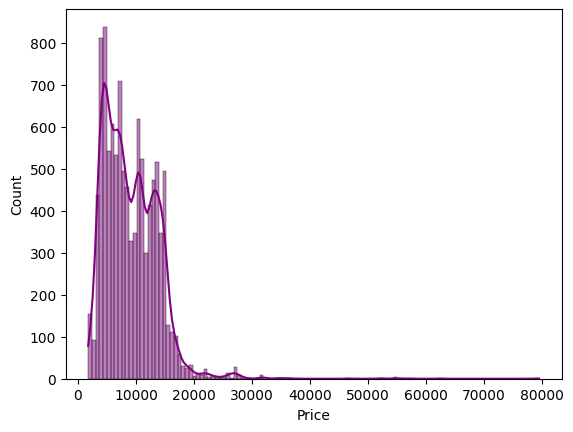

In [ ]:
# Plot histogram of Price
sns.histplot(df["Price"],kde=True,color="Purple")

# Print minimum ticket price
print("Min ticket price:", df["Price"].min())

# Print maximum ticket price
print("Max ticket price:", df["Price"].max())

# Print mean of ticket price
print("Mean ticket price:", df["Price"].mean())

The ticket price range is between 1500 and 20000. Whereas in some situations price even reached 80000.

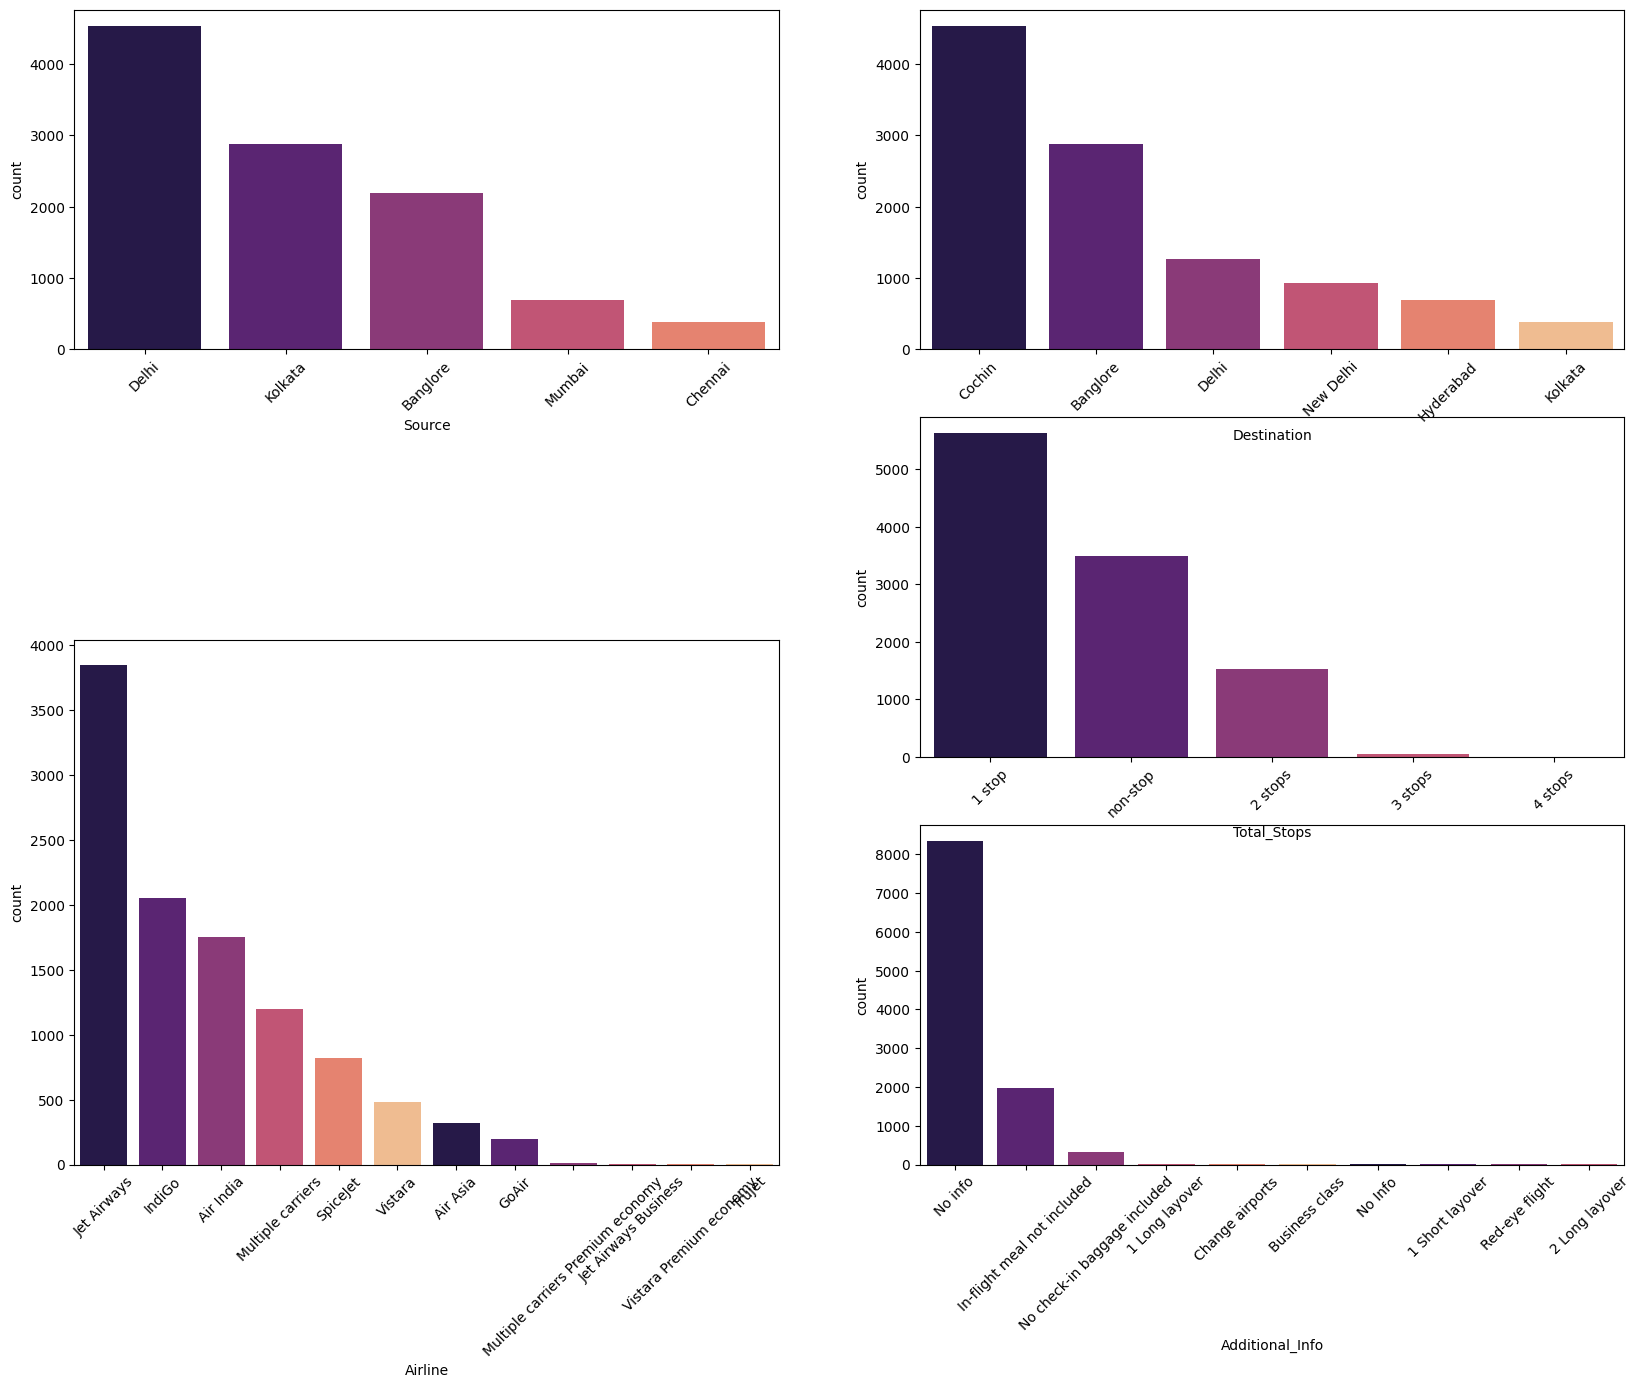

In [ ]:
# Set figure size to 20x15
plt.figure(figsize=(20,15))

# 1. Countplot of Airline
plt.subplot(2,2,3)
sns.countplot(x="Airline",data=df,palette=new_palette,order=df['Airline'].value_counts().index)
plt.xticks(rotation=45)

# 2. Countplot of Additional Info
plt.subplot(3,2,6)
sns.countplot(x="Additional_Info",data=df,palette=new_palette,order=df['Additional_Info'].value_counts().index)
plt.xticks(rotation=45)

# 3. Countplot of Total Stops
plt.subplot(3,2,4)
sns.countplot(x="Total_Stops",data=df,palette=new_palette,order=df['Total_Stops'].value_counts().index)
plt.xticks(rotation=45)

# 4. Countplot of Source
plt.subplot(3,2,1)
sns.countplot(x="Source",data=df,palette=new_palette,order=df['Source'].value_counts().index)
plt.xticks(rotation=45)

# 5. Countplot of Destination
plt.subplot(3,2,2)
sns.countplot(x="Destination",data=df,palette=new_palette,order=df['Destination'].value_counts().index)
plt.xticks(rotation=45)
plt.show()

- There are more datapoints for jet airways, 1 stop, Delhi, Cochin and no info.

### Bivariate Analysis

<Figure size 2000x1500 with 0 Axes>

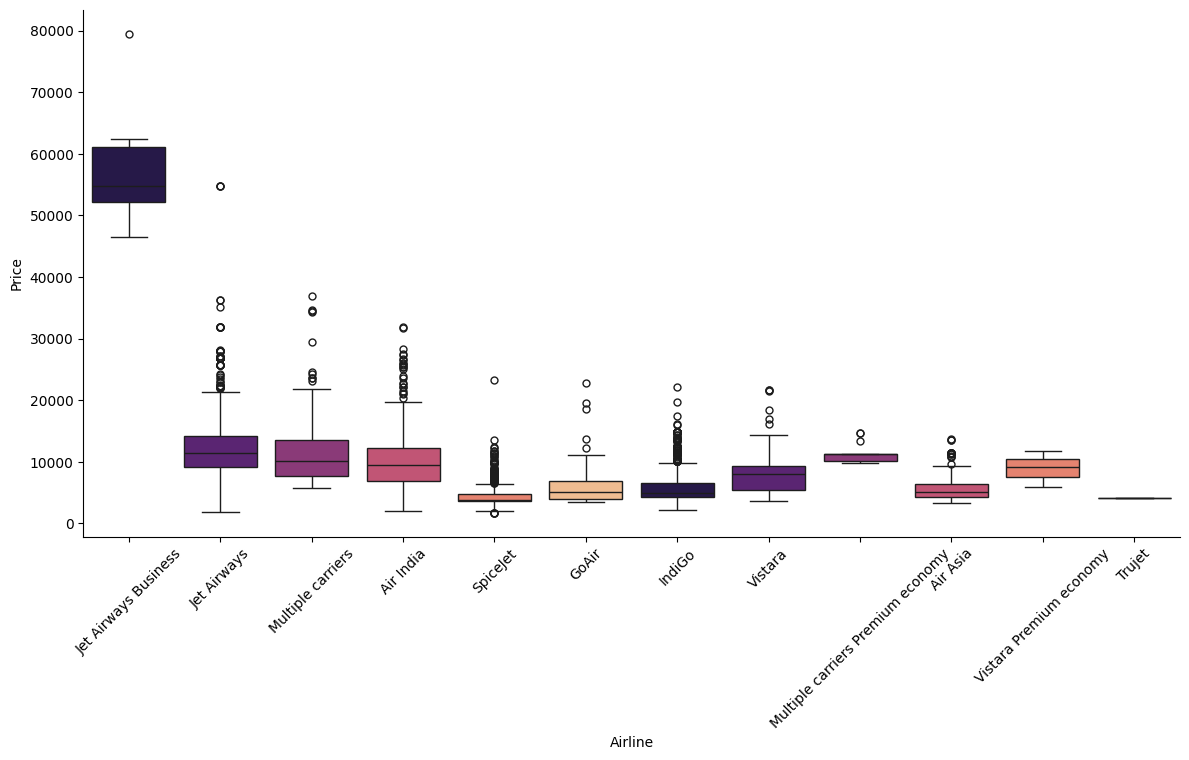

In [ ]:
# Set figure size
plt.figure(figsize=(20,15))

# Categorical plot for unique values in Airline feature by Price
sns.catplot(data=df.sort_values(by="Price",ascending=False),x="Airline",y="Price",kind="box", height = 6, aspect = 2, palette=new_palette)
plt.xticks(rotation=45)
plt.show()

- Jet Airways Business have highest Price of Tickets and the usual price ranges from 50000 to 60000. Also one of the ticket price is around 80000.
- Jet Airways, Multiple Carriers and Air India have a bit similar type of price range. But for on instance of Jet Airways, price was as high as 55000.
- There are outliers in SpiceJet, Jet Airways, Air India, Go Air.

<Figure size 2000x1500 with 0 Axes>

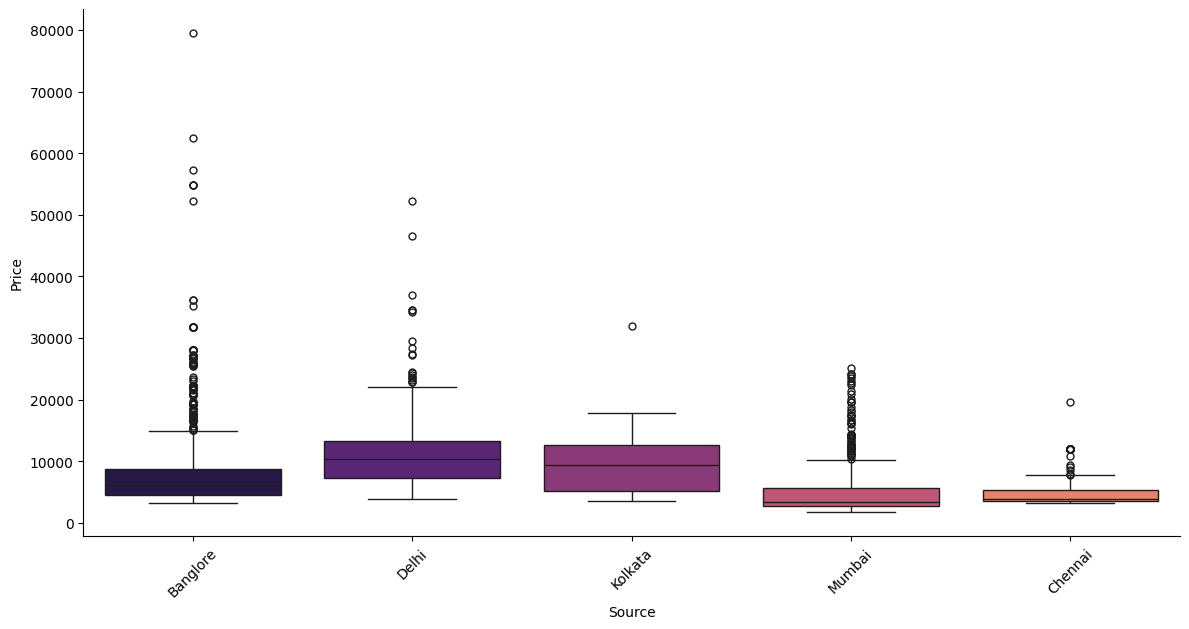

In [ ]:
plt.figure(figsize=(20,15))

# Categorical plot for unique values in Source feature by Price
sns.catplot(data=df.sort_values(by="Price",ascending=False),x="Source",y="Price",kind="box", height = 6, aspect = 2, palette=new_palette)
plt.xticks(rotation=45)
plt.show()

- The price range for travelling from Banglore is just below 30000 but in some situations ticket price even reached above 50000.
- Similarly For Delhi and Kolkata, price was above 40000 and 30000.

<Figure size 2000x1500 with 0 Axes>

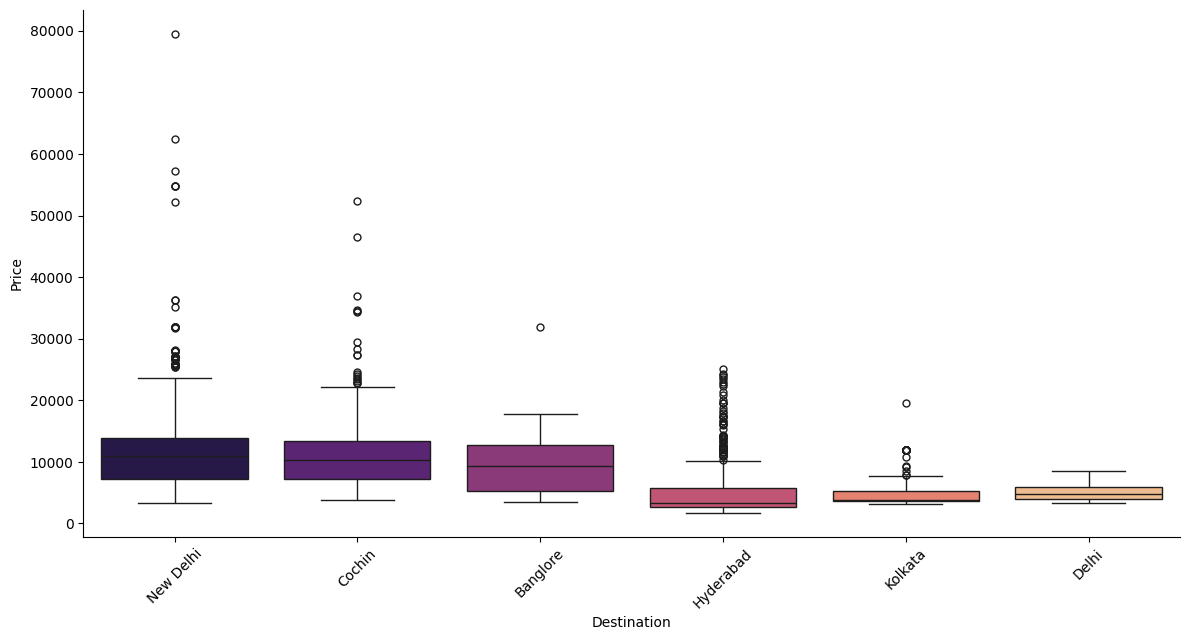

In [ ]:
plt.figure(figsize=(20,15))

# Categorical plot for unique values in Destination feature by Price
sns.catplot(data=df.sort_values(by="Price",ascending=False),x="Destination",y="Price",kind="box", height = 6, aspect = 2, palette=new_palette)
plt.xticks(rotation=45)
plt.show()

- When destination is New Delhi the ticket price for some instances were above 50000. Also, for Cochin there are two datapoints above 40000.
- For Banglore, usual price can be upto around 18000 but for one time it was above 30000.

<Figure size 2000x1500 with 0 Axes>

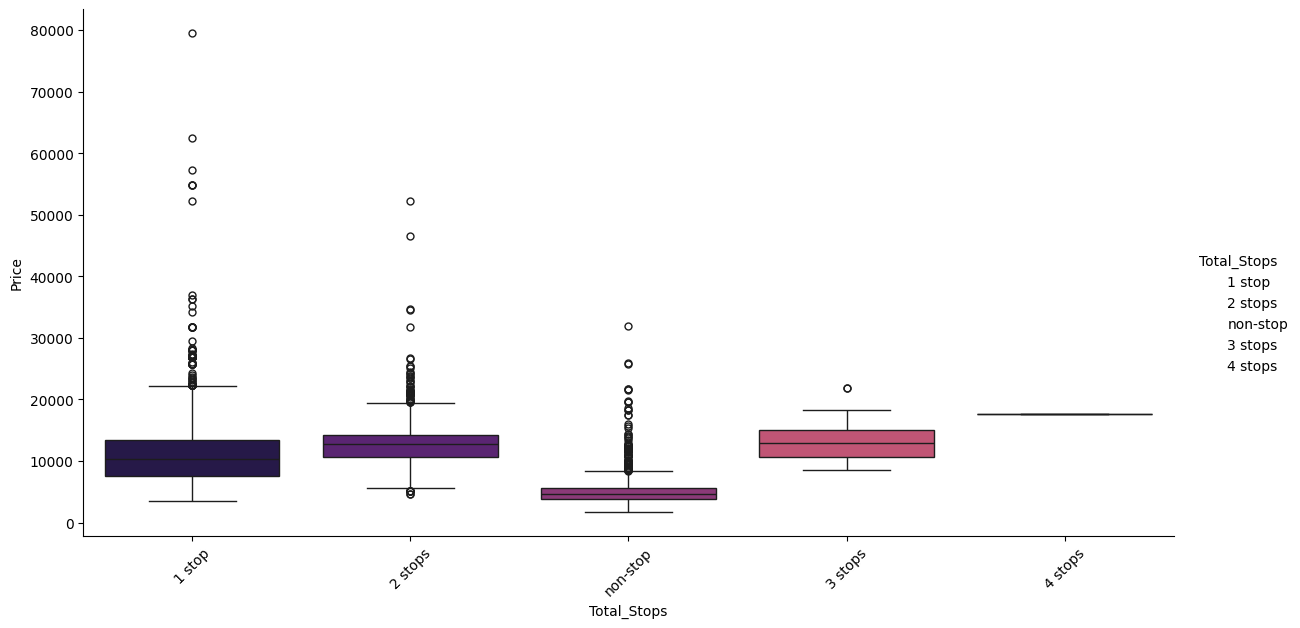

In [ ]:
plt.figure(figsize=(20,15))

# Categorical plot for unique values in Total_Stops feature by Price
sns.catplot(data=df.sort_values(by="Price",ascending=False),x="Total_Stops",y="Price",kind="box", height = 6, aspect = 2, palette=new_palette)
plt.xticks(rotation=45)
plt.show()

- For single stoppage in the flight there are visible outliers in the Price > 50000. Moreover, in two stopppage there are outliers above 40000.


<Figure size 2000x1500 with 0 Axes>

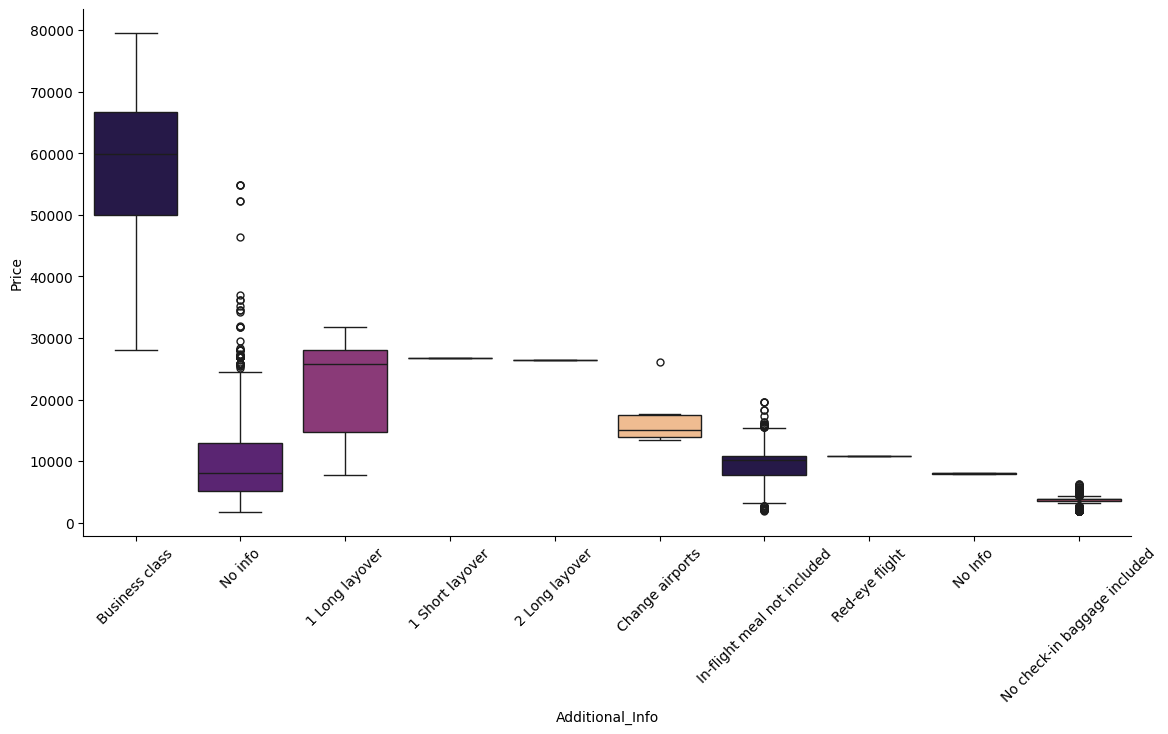

In [ ]:
plt.figure(figsize=(20,15))

# Categorical plot for unique values in Additional_Info feature by Price
sns.catplot(data=df.sort_values(by="Price",ascending=False),x="Additional_Info",y="Price",kind="box", height = 6, aspect = 2, palette=new_palette)
plt.xticks(rotation=45)
plt.show()

- The price range of Business Class is quite high.
- No info and Change Airport have outliers
- 1 short layover, 2 long layovers, and Red-eye flight have flat line as there are less datapoints for these additional information.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


## Data Preprocessing

A class is created to preprocess the data. This class contains method to remove, modify and add new features.

In [5]:
class Preprocessor:
  def __init__(self):
    pass

   # Method to preprocess the data
  def preprocess(self,X:pd.DataFrame):
    self.X = X
    self._lower_feature(["Airline","Source","Destination","Additional_Info"])
    self._one_hot_encode_features(["Airline","Source","Destination","Additional_Info"])
    self.X["Journey_day"],self.X["Journey_month"] = self._get_day_month(self.X["Date_of_Journey"])
    self.X["Arrival_hour"],self.X["Arrival_min"] = self._get_hour_minute(self.X["Arrival_Time"])
    self.X["Departure_hour"],self.X["Departure_min"] = self._get_hour_minute(self.X["Dep_Time"])
    self._remove_features(["Route","Date_of_Journey","Arrival_Time","Dep_Time"])
    self.X["Duration"] = self.X["Duration"].apply(self._preprocess_duration)
    self.X["Total_Stops"] = self.X["Total_Stops"].apply(self._preprocess_total_stops)
    return self.X

  # Method for applying one hot encoding
  def _one_hot_encode_features(self,features):
    for feature in features:
      dummy_df = pd.get_dummies(self.X,columns=[feature],dtype=int)
      self.X = dummy_df.copy()

  # Method to remove features
  def _remove_features(self,features):
    self.X.drop(columns = features,inplace=True)

  # Method to preprocess duration
  def _preprocess_duration(self,duration):
    duration_list = re.split(r"\D+",duration)
    if len(duration_list) == 3:
      hours, minutes = duration_list[0:2]
      return int(hours) * 60 + int(minutes)
    else:
      hours = duration_list[0]
      return int(hours) * 60

  # Method to preprocess total stops
  def _preprocess_total_stops(self,total_stops):
    if total_stops == "non-stop":
      return 0
    else:
      return int(re.split(r"\D+",total_stops)[0])

  # Method to lower the feature
  def _lower_feature(self,features):
    for feature in features:
      self.X[feature] = self.X[feature].str.lower()

  # Method to get day and month
  def _get_day_month(self,inp_day):
    day = pd.to_datetime(inp_day,format="mixed").dt.day.astype(int)
    month = pd.to_datetime(inp_day,format="mixed").dt.month.astype(int)
    return day,month

  # Method to get hour and minute
  def _get_hour_minute(self,inp_time):
    hour = pd.to_datetime(inp_time).dt.hour.astype(int)
    minute = pd.to_datetime(inp_time).dt.minute.astype(int)
    return hour,minute

In [6]:
# Object of Preprocessor class
preprocessor = Preprocessor()

# Preprocess the data
new_df = preprocessor.preprocess(df.copy())
new_df.head()

,Duration,Total_Stops,Price,Airline_air asia,Airline_air india,Airline_goair,Airline_indigo,Airline_jet airways,Airline_jet airways business,Airline_multiple carriers,...,Additional_Info_in-flight meal not included,Additional_Info_no check-in baggage included,Additional_Info_no info,Additional_Info_red-eye flight,Journey_day,Journey_month,Arrival_hour,Arrival_min,Departure_hour,Departure_min
0,170,0,3897,0,0,0,1,0,0,0,...,0,0,1,0,24,3,1,10,22,20
1,445,2,7662,0,1,0,0,0,0,0,...,0,0,1,0,5,1,13,15,5,50
2,1140,2,13882,0,0,0,0,1,0,0,...,0,0,1,0,6,9,4,25,9,25
3,325,1,6218,0,0,0,1,0,0,0,...,0,0,1,0,5,12,23,30,18,5
4,285,1,13302,0,0,0,1,0,0,0,...,0,0,1,0,3,1,21,35,16,50


In [9]:
new_df["Journey_month"].value_counts()

Journey_month
6     2535
3     2211
5     2074
9     1406
1     1075
12     957
4      424
Name: count, dtype: int64

<Axes: xlabel='Departure_hour', ylabel='Price'>

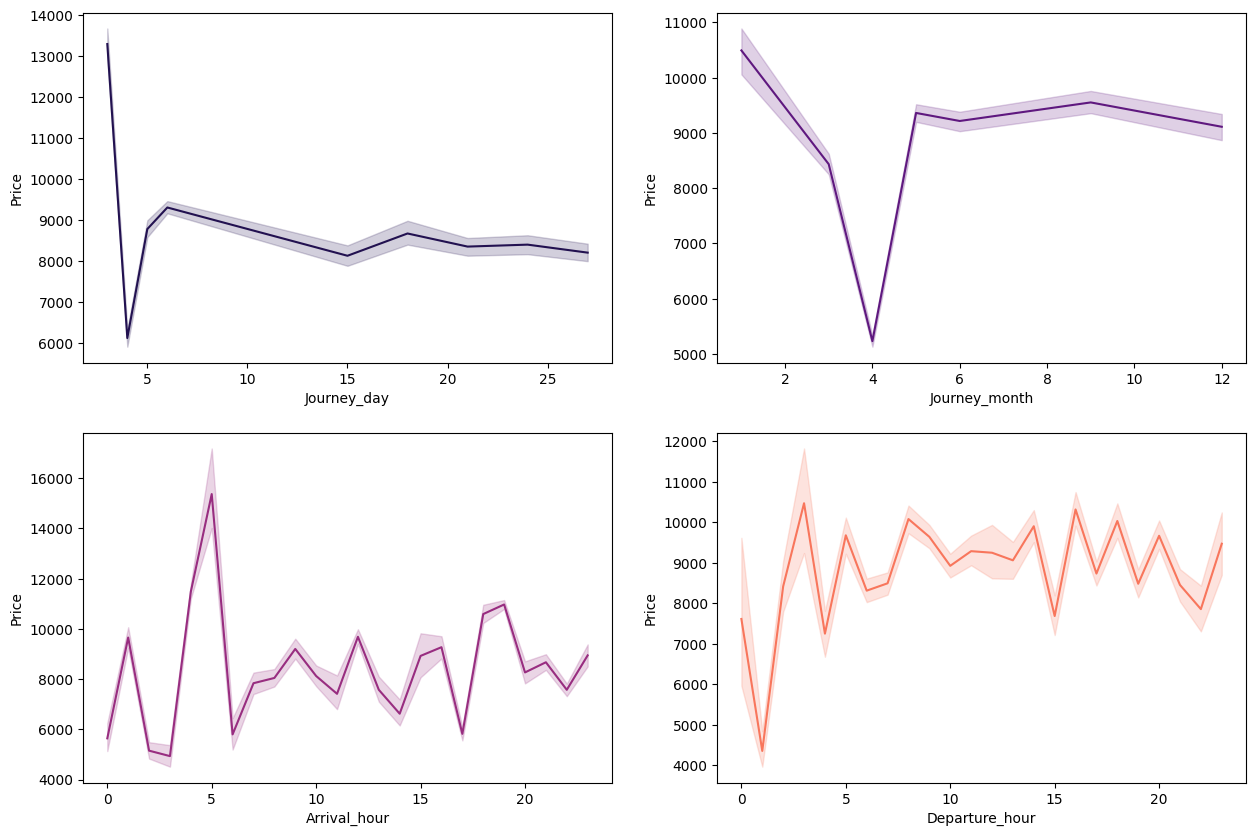

In [ ]:
# Set figure size
plt.figure(figsize=(15,10))

# 1. Journey Day vs. Price
plt.subplot(2,2,1)
sns.lineplot(data=new_df,x="Journey_day",y="Price",color=new_palette[0])

# 2. Journey Month vs. Price
plt.subplot(2,2,2)
sns.lineplot(data=new_df,x="Journey_month",y="Price",color=new_palette[1])

# 3. Arrival Hour vs. Price
plt.subplot(2,2,3)
sns.lineplot(data=new_df,x="Arrival_hour",y="Price",color=new_palette[2])

# 4. Departure Hour vs. Price
plt.subplot(2,2,4)
sns.lineplot(data=new_df,x="Departure_hour",y="Price",color=new_palette[4])



- Initial days of the month have higher price ie from 1 to 5. Afterwards, the price remains between 8000 and 9000
- For every month the price remained above 9000 but for April price dropped below 6000.
- The price are high if arrival time is 5 then price is high else it remains below 10000.
- When Departure hour is greater than 2 the price remains above 7000.

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 41 columns):
 #   Column                                        Non-Null Count  Dtype
---  ------                                        --------------  -----
 0   Duration                                      10682 non-null  int64
 1   Total_Stops                                   10682 non-null  int64
 2   Price                                         10682 non-null  int64
 3   Airline_air asia                              10682 non-null  int64
 4   Airline_air india                             10682 non-null  int64
 5   Airline_goair                                 10682 non-null  int64
 6   Airline_indigo                                10682 non-null  int64
 7   Airline_jet airways                           10682 non-null  int64
 8   Airline_jet airways business                  10682 non-null  int64
 9   Airline_multiple carriers                     10682 non-null  int64
 10  Airline_multipl

In [ ]:
# Describe processed data
new_df.describe()

,Duration,Total_Stops,Price,Airline_air asia,Airline_air india,Airline_goair,Airline_indigo,Airline_jet airways,Airline_jet airways business,Airline_multiple carriers,...,Additional_Info_in-flight meal not included,Additional_Info_no check-in baggage included,Additional_Info_no info,Additional_Info_red-eye flight,Journey_day,Journey_month,Arrival_hour,Arrival_min,Departure_hour,Departure_min
count,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,...,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000
mean,643.048118,0.824190,9087.214567,0.029863,0.163921,0.018161,0.192192,0.360326,0.000562,0.111964,...,0.185546,0.029957,0.781408,0.000094,12.682925,5.534731,13.349186,24.690601,12.491013,24.409287
std,507.803454,0.675229,4611.548810,0.170218,0.370221,0.133541,0.394042,0.480117,0.023695,0.315337,...,0.388758,0.170477,0.413310,0.009676,8.803800,2.987626,6.859317,16.506808,5.748820,18.767801
min,75.000000,0.000000,1759.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,170.000000,0.000000,5277.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,5.000000,3.000000,8.000000,10.000000,8.000000,5.000000
50%,520.000000,1.000000,8372.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,6.000000,5.000000,14.000000,25.000000,11.000000,25.000000
75%,930.000000,1.000000,12373.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,21.000000,6.000000,19.000000,35.000000,18.000000,40.000000
max,2860.000000,4.000000,79512.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,27.000000,12.000000,23.000000,55.000000,23.000000,55.000000


<Axes: >

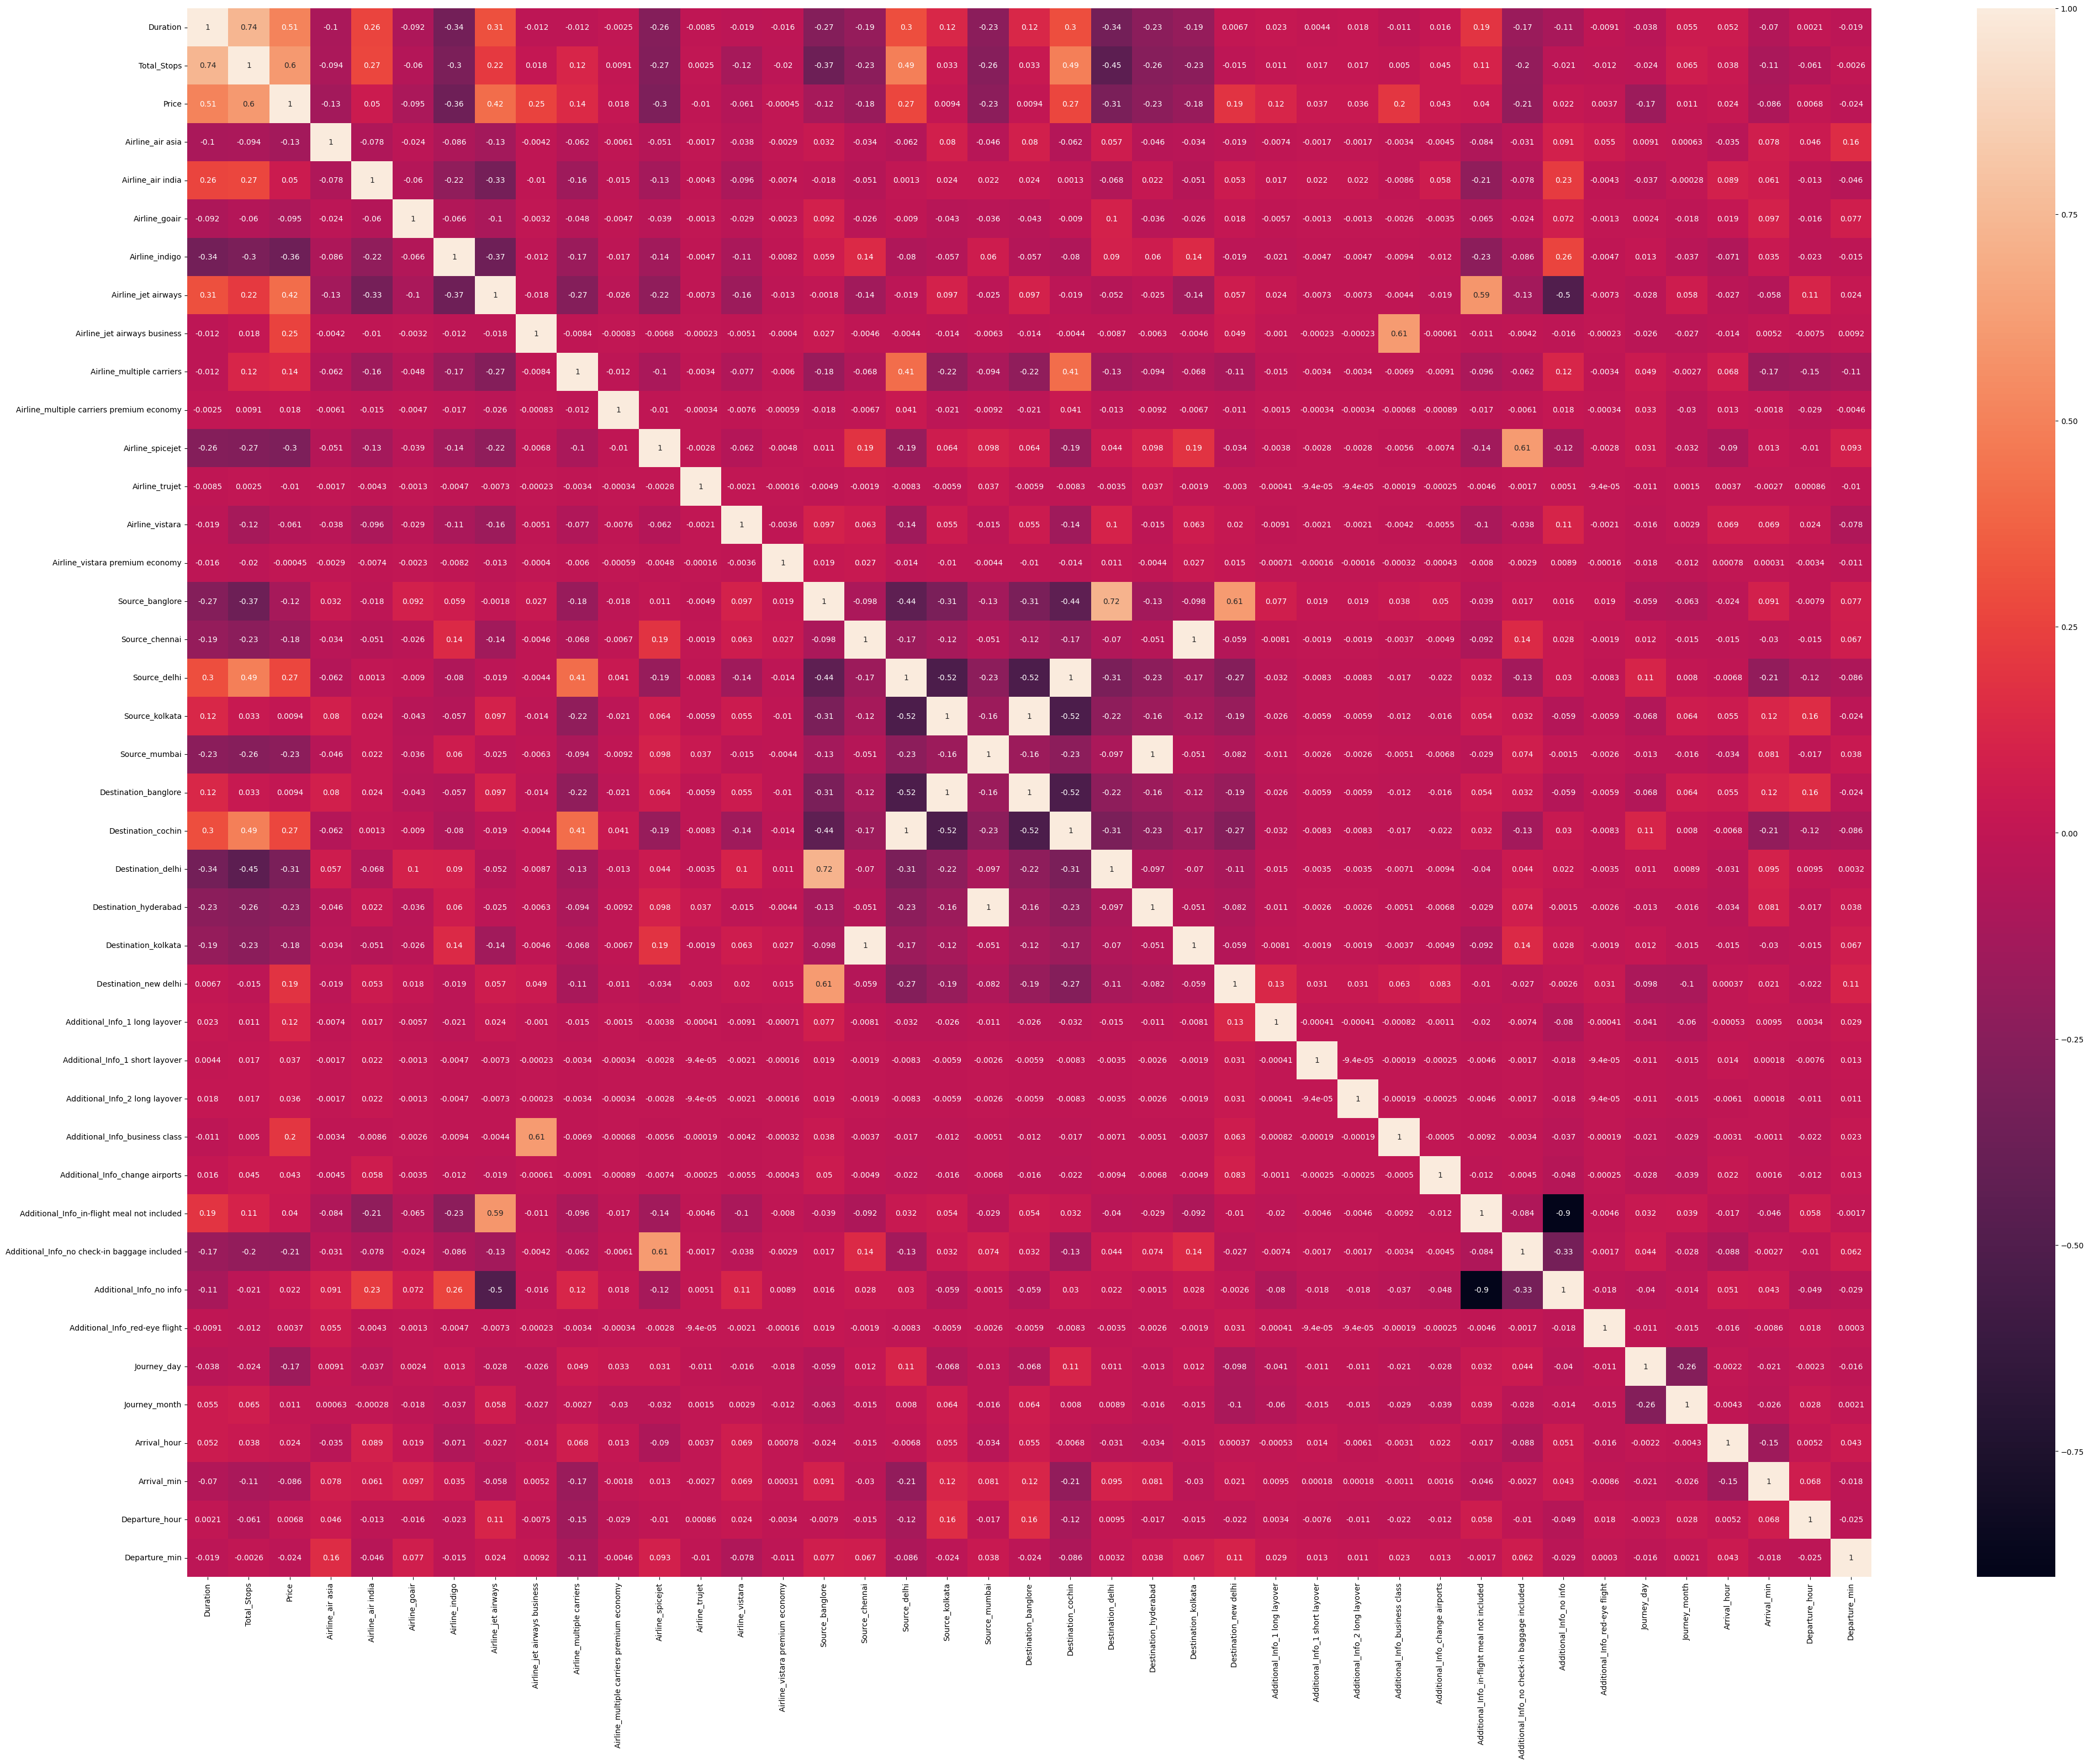

In [ ]:
# Total number of features
num_features = len(new_df.corr().columns)

# Set figure size
fig_size = (num_features * 1.2, num_features * 0.9)

# Plot heatmap
plt.figure(figsize=fig_size)
sns.heatmap(new_df.corr(),annot=True)

In [ ]:
# Independent variables
X = new_df.drop(columns=["Airline_vistara premium economy","Additional_Info_1 short layover","Additional_Info_2 long layover"
,"Airline_trujet","Source_kolkata","Destination_banglore","Additional_Info_red-eye flight","Price"])

# Target variable
y = new_df["Price"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Function to store score of different models
def add_result(result_df, model_name):

  # Compute MSE
  mse = mean_squared_error(y_test,y_pred)

  # Compute MAE
  mae = mean_absolute_error(y_test,y_pred)

  # Compute R2
  r2 = r2_score(y_test,y_pred)

  # Create dataframe for result
  temp_df =  pd.DataFrame([mse,mae,r2],columns=[model_name]).T

  # Rename columns
  temp_df.columns = ["MSE","MAE","R2"]

  # Concatenate dataframe
  result_df = pd.concat([result_df,temp_df])

  # Return dataframe
  return result_df

## Model Training

### Random Forest Regressor

In [ ]:
# Random Forest Regressor Model
RFR = RandomForestRegressor()

# Fit the model
RFR.fit(X_train,y_train)

# Predict the target variable
y_pred = RFR.predict(X_test)

In [ ]:
# Compute MSE
mse = mean_squared_error(y_test,y_pred)
print(f"mse:{mse}")

# Compute MAE
mae = mean_absolute_error(y_test,y_pred)
print(f"mae:{mae}")

# Compute R2
r2 = r2_score(y_test,y_pred)
print(f"r2:{r2}")

mse:2253971.785865184
mae:655.8830281120247
r2:0.8954658242247772


In [ ]:
# Dataframe for result
result_df = pd.DataFrame([mse,mae,r2],columns=["Random Forest Regressor"])

# Transpose the result dataframe
result_df = result_df.T

# Rename columns
result_df = result_df.rename(columns = {0: "MSE",1: "MAE",2: "R2"})

# Print result dataframe
result_df

,MSE,MAE,R2
Random Forest Regressor,2.253972e+06,655.883028,0.895466


<Axes: >

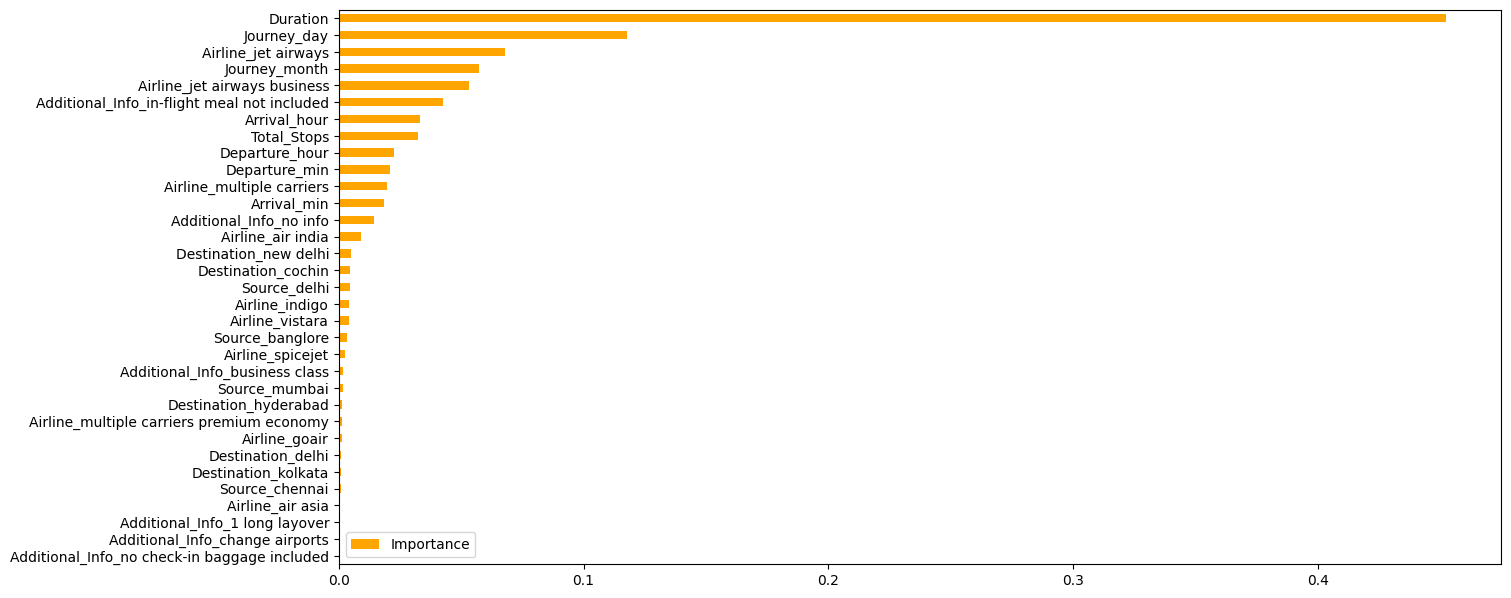

In [ ]:
# Create Dataframe for feature importance
feature_importances = pd.DataFrame(RFR.feature_importances_, index = X.columns,
                                   columns=['Importance']).sort_values('Importance', ascending = True)

# Plot horizontal barchart of feature importance
feature_importances.sort_values(by = 'Importance', ascending = True).plot(kind = 'barh', figsize = (15, 7.2),color="orange")

In [ ]:
# Find features that have importance greater than 0.0013
feature_importances[feature_importances["Importance"] >= 0.0013].index

Index(['Airline_multiple carriers premium economy', 'Destination_hyderabad',
       'Source_mumbai', 'Additional_Info_business class', 'Airline_spicejet',
       'Source_banglore', 'Airline_vistara', 'Airline_indigo', 'Source_delhi',
       'Destination_cochin', 'Destination_new delhi', 'Airline_air india',
       'Additional_Info_no info', 'Arrival_min', 'Airline_multiple carriers',
       'Departure_min', 'Departure_hour', 'Total_Stops', 'Arrival_hour',
       'Additional_Info_in-flight meal not included',
       'Airline_jet airways business', 'Journey_month', 'Airline_jet airways',
       'Journey_day', 'Duration'],
      dtype='object')

In [ ]:
# Independent Variable
X = new_df[['Airline_multiple carriers premium economy', 'Source_mumbai',
       'Destination_hyderabad', 'Airline_spicejet',
       'Additional_Info_business class', 'Source_banglore', 'Source_delhi',
       'Airline_vistara', 'Destination_cochin', 'Destination_new delhi',
       'Airline_indigo', 'Airline_air india', 'Additional_Info_no info',
       'Arrival_min', 'Airline_multiple carriers', 'Departure_min',
       'Departure_hour', 'Arrival_hour', 'Total_Stops',
       'Additional_Info_in-flight meal not included',
       'Airline_jet airways business', 'Journey_month', 'Airline_jet airways',
       'Journey_day', 'Duration']]

# Target Variable
y = new_df["Price"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Decision Tree Regressor

In [ ]:
# Decision Tree Regressor Model
DTR = DecisionTreeRegressor()

# Fit the model
DTR.fit(X_train,y_train)

# Predict the target variable
y_pred = DTR.predict(X_test)

In [ ]:
# Add result to result dataframe
result_df = add_result(result_df,"Decision Tree")
result_df

,MSE,MAE,R2
Random Forest Regressor,2.253972e+06,655.883028,0.895466
Decision Tree,2.676328e+06,703.382702,0.875878


<Axes: >

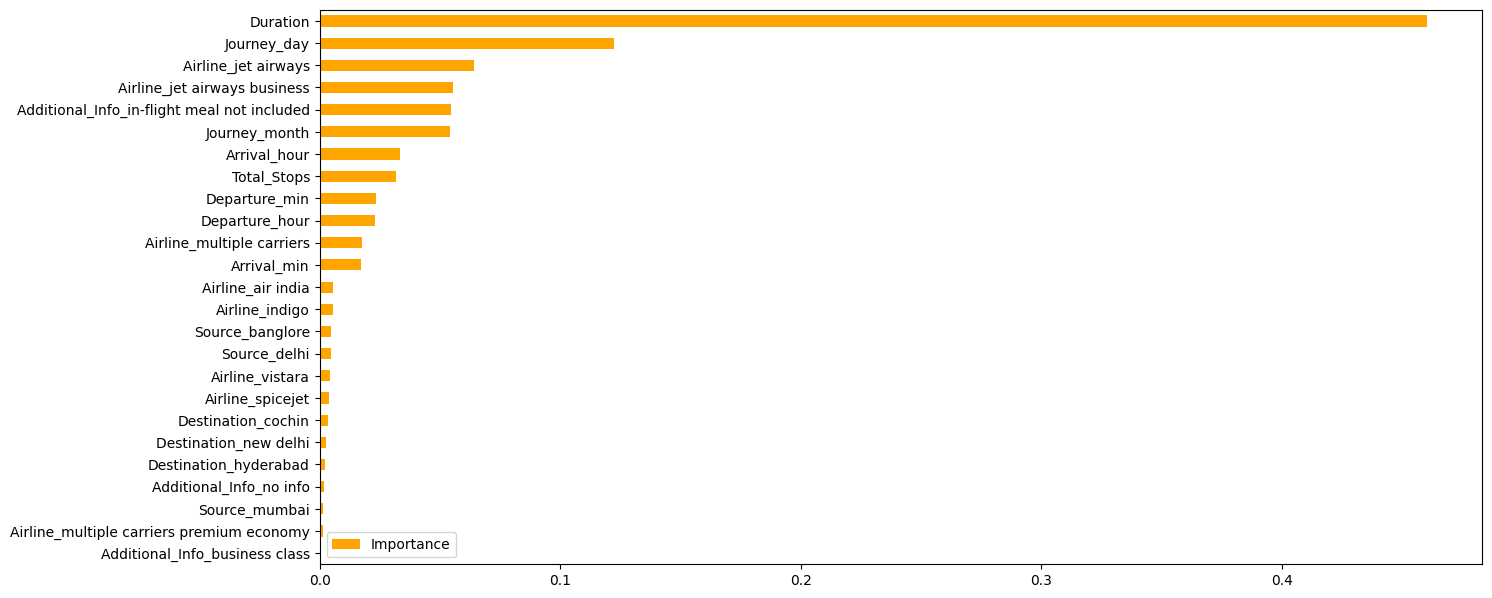

In [ ]:
# Create Dataframe for feature importance
feature_importances = pd.DataFrame(DTR.feature_importances_, index = X.columns,
                                   columns=['Importance']).sort_values('Importance', ascending = True)

# Plot horizontal barchart of feature importance
feature_importances.sort_values(by = 'Importance', ascending = True).plot(kind = 'barh', figsize = (15, 7.2),color="orange")

### Linear Regression

In [ ]:
# Linear Regression Model
LR = LinearRegression()

# Fit the model
LR.fit(X_train,y_train)

# Predict the target variable
y_pred = LR.predict(X_test)

In [ ]:
# Limit the floating points to 4 decimal places
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [ ]:
# Add result to result dataframe
result_df = add_result(result_df,"Linear Regression")
result_df

,MSE,MAE,R2
Random Forest Regressor,2253971.7859,655.8830,0.8955
Decision Tree,2676327.9853,703.3827,0.8759
Linear Regression,6911051.1049,1804.1296,0.6795


## Predicting Test Data

In [ ]:
# Load testing data
X_test = pd.read_excel("/content/drive/MyDrive/Datasets/Flight_Ticket_Participant_Datasets/Test_set.xlsx")

# Preprocess test data
X_test = preprocessor.preprocess(X_test)

# Drop features
X_test = X_test.drop(columns=["Airline_vistara premium economy","Source_kolkata","Destination_banglore"])

In [ ]:
# Predict price using Random Forest Regressor
RFR.predict(X_test)

array([14451.15,  4259.17, 12898.  , ..., 16201.04, 13208.63,  7529.74])

In [ ]:
# Load the testing data
X_test = pd.read_excel("/content/drive/MyDrive/Datasets/Flight_Ticket_Participant_Datasets/Test_set.xlsx")

# Preprocess the test data
X_test = preprocessor.preprocess(X_test)

# Drop features
X_test = X_test[['Airline_multiple carriers premium economy', 'Source_mumbai',
       'Destination_hyderabad', 'Airline_spicejet',
       'Additional_Info_business class', 'Source_banglore', 'Source_delhi',
       'Airline_vistara', 'Destination_cochin', 'Destination_new delhi',
       'Airline_indigo', 'Airline_air india', 'Additional_Info_no info',
       'Arrival_min', 'Airline_multiple carriers', 'Departure_min',
       'Departure_hour', 'Arrival_hour', 'Total_Stops',
       'Additional_Info_in-flight meal not included',
       'Airline_jet airways business', 'Journey_month', 'Airline_jet airways',
       'Journey_day', 'Duration']]

In [ ]:
# Predict price using Decision Tree Regressor
DTR.predict(X_test)

array([14714.,  4226., 12898., ..., 15029., 11050.,  7155.])

In [ ]:
# Predict price using Linear Regression
LR.predict(X_test)

array([13961.11079485,  7139.5257375 ,  9409.45027459, ...,
       14126.04108626,  9473.59044785, 10773.31165198])